# cbow.py

In [10]:
# coding: utf-8
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Embedding
# from ch04.negative_sampling_layer import NegativeSamplingLoss


class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

# eval.py

In [11]:
# coding: utf-8
import sys
sys.path.append('..')
from common.util import most_similar, analogy
import pickle


pkl_file = 'cbow_params.pkl'
# pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[query] you
 we: 0.6103515625
 someone: 0.59130859375
 i: 0.55419921875
 something: 0.48974609375
 anyone: 0.47314453125

[query] year
 month: 0.71875
 week: 0.65234375
 spring: 0.62744140625
 summer: 0.6259765625
 decade: 0.603515625

[query] car
 luxury: 0.497314453125
 arabia: 0.47802734375
 auto: 0.47119140625
 disk-drive: 0.450927734375
 travel: 0.4091796875

[query] toyota
 ford: 0.55078125
 instrumentation: 0.509765625
 mazda: 0.49365234375
 bethlehem: 0.47509765625
 nissan: 0.474853515625
--------------------------------------------------

[analogy] king:man = queen:?
 woman: 5.16015625
 veto: 4.9296875
 ounce: 4.69140625
 earthquake: 4.6328125
 successor: 4.609375

[analogy] take:took = go:?
 went: 4.55078125
 points: 4.25
 began: 4.09375
 comes: 3.98046875
 oct.: 3.90625

[analogy] car:cars = child:?
 children: 5.21875
 average: 4.7265625
 yield: 4.20703125
 cattle: 4.1875
 priced: 4.1796875

[analogy] good:better = bad:?
 more: 6.6484375
 less: 6.0625
 rather: 5.21875
 slow

# negative_sampling_layer.py

In [12]:
# coding: utf-8
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Embedding, SigmoidWithLoss
import collections


class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh


class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice-(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample


class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

# skip_gram.py

In [13]:
# coding: utf-8
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.layers import *
# from ch04.negative_sampling_layer import NegativeSamplingLoss


class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # 계층 생성
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None


# train.py

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 1[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 2[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 3[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 4[s] | 손실 3.92
| 에폭 1 |  반복 121 / 9295 | 시간 5[s] | 손실 3.78
| 에폭 1 |  반복 141 / 9295 | 시간 5[s] | 손실 3.62
| 에폭 1 |  반복 161 / 9295 | 시간 6[s] | 손실 3.48
| 에폭 1 |  반복 181 / 9295 | 시간 7[s] | 손실 3.37
| 에폭 1 |  반복 201 / 9295 | 시간 8[s] | 손실 3.25
| 에폭 1 |  반복 221 / 9295 | 시간 9[s] | 손실 3.16
| 에폭 1 |  반복 241 / 9295 | 시간 9[s] | 손실 3.09
| 에폭 1 |  반복 261 / 9295 | 시간 10[s] | 손실 3.02
| 에폭 1 |  반복 281 / 9295 | 시간 11[s] | 손실 2.98
| 에폭 1 |  반복 301 / 9295 | 시간 12[s] | 손실 2.91
| 에폭 1 |  반복 321 / 9295 | 시간 13[s] | 손실 2.89
| 에폭 1 |  반복 341 / 9295 | 시간 14[s] | 손실 2.84
| 에폭 1 |  반복 361 / 9295 | 시간 14[s] | 손실 2.82
| 에폭 1 |  반복 381 / 9295 | 시간 15[s] | 손실 2.80
| 에폭 1 |  반복 401 / 9295 | 시간 16[s] | 손실 2.77
| 에폭 1 |  반복 421 / 9295 | 시간 17[s] | 손실 2.74
| 에폭 1 |  반복 441 / 9295 | 시간 

| 에폭 1 |  반복 3581 / 9295 | 시간 139[s] | 손실 2.41
| 에폭 1 |  반복 3601 / 9295 | 시간 139[s] | 손실 2.45
| 에폭 1 |  반복 3621 / 9295 | 시간 140[s] | 손실 2.41
| 에폭 1 |  반복 3641 / 9295 | 시간 141[s] | 손실 2.41
| 에폭 1 |  반복 3661 / 9295 | 시간 142[s] | 손실 2.39
| 에폭 1 |  반복 3681 / 9295 | 시간 142[s] | 손실 2.42
| 에폭 1 |  반복 3701 / 9295 | 시간 143[s] | 손실 2.39
| 에폭 1 |  반복 3721 / 9295 | 시간 144[s] | 손실 2.40
| 에폭 1 |  반복 3741 / 9295 | 시간 144[s] | 손실 2.40
| 에폭 1 |  반복 3761 / 9295 | 시간 145[s] | 손실 2.42
| 에폭 1 |  반복 3781 / 9295 | 시간 146[s] | 손실 2.44
| 에폭 1 |  반복 3801 / 9295 | 시간 147[s] | 손실 2.41
| 에폭 1 |  반복 3821 / 9295 | 시간 147[s] | 손실 2.39
| 에폭 1 |  반복 3841 / 9295 | 시간 148[s] | 손실 2.40
| 에폭 1 |  반복 3861 / 9295 | 시간 149[s] | 손실 2.42
| 에폭 1 |  반복 3881 / 9295 | 시간 150[s] | 손실 2.38
| 에폭 1 |  반복 3901 / 9295 | 시간 150[s] | 손실 2.39
| 에폭 1 |  반복 3921 / 9295 | 시간 151[s] | 손실 2.43
| 에폭 1 |  반복 3941 / 9295 | 시간 152[s] | 손실 2.43
| 에폭 1 |  반복 3961 / 9295 | 시간 153[s] | 손실 2.40
| 에폭 1 |  반복 3981 / 9295 | 시간 153[s] | 손실 2.41
| 에폭 1 |  반복 

| 에폭 1 |  반복 7081 / 9295 | 시간 268[s] | 손실 2.30
| 에폭 1 |  반복 7101 / 9295 | 시간 269[s] | 손실 2.29
| 에폭 1 |  반복 7121 / 9295 | 시간 270[s] | 손실 2.28
| 에폭 1 |  반복 7141 / 9295 | 시간 271[s] | 손실 2.29
| 에폭 1 |  반복 7161 / 9295 | 시간 271[s] | 손실 2.27
| 에폭 1 |  반복 7181 / 9295 | 시간 272[s] | 손실 2.28
| 에폭 1 |  반복 7201 / 9295 | 시간 273[s] | 손실 2.27
| 에폭 1 |  반복 7221 / 9295 | 시간 273[s] | 손실 2.29
| 에폭 1 |  반복 7241 / 9295 | 시간 274[s] | 손실 2.27
| 에폭 1 |  반복 7261 / 9295 | 시간 275[s] | 손실 2.24
| 에폭 1 |  반복 7281 / 9295 | 시간 276[s] | 손실 2.29
| 에폭 1 |  반복 7301 / 9295 | 시간 276[s] | 손실 2.26
| 에폭 1 |  반복 7321 / 9295 | 시간 277[s] | 손실 2.28
| 에폭 1 |  반복 7341 / 9295 | 시간 278[s] | 손실 2.28
| 에폭 1 |  반복 7361 / 9295 | 시간 279[s] | 손실 2.27
| 에폭 1 |  반복 7381 / 9295 | 시간 279[s] | 손실 2.24
| 에폭 1 |  반복 7401 / 9295 | 시간 280[s] | 손실 2.26
| 에폭 1 |  반복 7421 / 9295 | 시간 281[s] | 손실 2.25
| 에폭 1 |  반복 7441 / 9295 | 시간 282[s] | 손실 2.26
| 에폭 1 |  반복 7461 / 9295 | 시간 282[s] | 손실 2.24
| 에폭 1 |  반복 7481 / 9295 | 시간 283[s] | 손실 2.27
| 에폭 1 |  반복 

| 에폭 2 |  반복 1301 / 9295 | 시간 399[s] | 손실 2.15
| 에폭 2 |  반복 1321 / 9295 | 시간 399[s] | 손실 2.14
| 에폭 2 |  반복 1341 / 9295 | 시간 400[s] | 손실 2.17
| 에폭 2 |  반복 1361 / 9295 | 시간 401[s] | 손실 2.16
| 에폭 2 |  반복 1381 / 9295 | 시간 402[s] | 손실 2.15
| 에폭 2 |  반복 1401 / 9295 | 시간 402[s] | 손실 2.15
| 에폭 2 |  반복 1421 / 9295 | 시간 403[s] | 손실 2.18
| 에폭 2 |  반복 1441 / 9295 | 시간 404[s] | 손실 2.16
| 에폭 2 |  반복 1461 / 9295 | 시간 405[s] | 손실 2.16
| 에폭 2 |  반복 1481 / 9295 | 시간 405[s] | 손실 2.15
| 에폭 2 |  반복 1501 / 9295 | 시간 406[s] | 손실 2.13
| 에폭 2 |  반복 1521 / 9295 | 시간 407[s] | 손실 2.14
| 에폭 2 |  반복 1541 / 9295 | 시간 408[s] | 손실 2.15
| 에폭 2 |  반복 1561 / 9295 | 시간 408[s] | 손실 2.14
| 에폭 2 |  반복 1581 / 9295 | 시간 409[s] | 손실 2.13
| 에폭 2 |  반복 1601 / 9295 | 시간 410[s] | 손실 2.16
| 에폭 2 |  반복 1621 / 9295 | 시간 411[s] | 손실 2.15
| 에폭 2 |  반복 1641 / 9295 | 시간 411[s] | 손실 2.13
| 에폭 2 |  반복 1661 / 9295 | 시간 412[s] | 손실 2.13
| 에폭 2 |  반복 1681 / 9295 | 시간 413[s] | 손실 2.18
| 에폭 2 |  반복 1701 / 9295 | 시간 413[s] | 손실 2.15
| 에폭 2 |  반복 

| 에폭 2 |  반복 4801 / 9295 | 시간 527[s] | 손실 2.10
| 에폭 2 |  반복 4821 / 9295 | 시간 527[s] | 손실 2.06
| 에폭 2 |  반복 4841 / 9295 | 시간 528[s] | 손실 2.09
| 에폭 2 |  반복 4861 / 9295 | 시간 529[s] | 손실 2.11
| 에폭 2 |  반복 4881 / 9295 | 시간 530[s] | 손실 2.07
| 에폭 2 |  반복 4901 / 9295 | 시간 530[s] | 손실 2.07
| 에폭 2 |  반복 4921 / 9295 | 시간 531[s] | 손실 2.09
| 에폭 2 |  반복 4941 / 9295 | 시간 532[s] | 손실 2.05
| 에폭 2 |  반복 4961 / 9295 | 시간 532[s] | 손실 2.10
| 에폭 2 |  반복 4981 / 9295 | 시간 533[s] | 손실 2.07
| 에폭 2 |  반복 5001 / 9295 | 시간 534[s] | 손실 2.08
| 에폭 2 |  반복 5021 / 9295 | 시간 535[s] | 손실 2.11
| 에폭 2 |  반복 5041 / 9295 | 시간 535[s] | 손실 2.07
| 에폭 2 |  반복 5061 / 9295 | 시간 536[s] | 손실 2.07
| 에폭 2 |  반복 5081 / 9295 | 시간 537[s] | 손실 2.06
| 에폭 2 |  반복 5101 / 9295 | 시간 537[s] | 손실 2.05
| 에폭 2 |  반복 5121 / 9295 | 시간 538[s] | 손실 2.09
| 에폭 2 |  반복 5141 / 9295 | 시간 539[s] | 손실 2.07
| 에폭 2 |  반복 5161 / 9295 | 시간 540[s] | 손실 2.09
| 에폭 2 |  반복 5181 / 9295 | 시간 540[s] | 손실 2.11
| 에폭 2 |  반복 5201 / 9295 | 시간 541[s] | 손실 2.05
| 에폭 2 |  반복 

| 에폭 2 |  반복 8301 / 9295 | 시간 653[s] | 손실 2.04
| 에폭 2 |  반복 8321 / 9295 | 시간 654[s] | 손실 1.99
| 에폭 2 |  반복 8341 / 9295 | 시간 655[s] | 손실 2.03
| 에폭 2 |  반복 8361 / 9295 | 시간 655[s] | 손실 2.05
| 에폭 2 |  반복 8381 / 9295 | 시간 656[s] | 손실 2.04
| 에폭 2 |  반복 8401 / 9295 | 시간 657[s] | 손실 2.01
| 에폭 2 |  반복 8421 / 9295 | 시간 657[s] | 손실 2.04
| 에폭 2 |  반복 8441 / 9295 | 시간 658[s] | 손실 2.02
| 에폭 2 |  반복 8461 / 9295 | 시간 659[s] | 손실 2.02
| 에폭 2 |  반복 8481 / 9295 | 시간 660[s] | 손실 2.04
| 에폭 2 |  반복 8501 / 9295 | 시간 660[s] | 손실 2.09
| 에폭 2 |  반복 8521 / 9295 | 시간 661[s] | 손실 2.04
| 에폭 2 |  반복 8541 / 9295 | 시간 662[s] | 손실 2.06
| 에폭 2 |  반복 8561 / 9295 | 시간 663[s] | 손실 1.99
| 에폭 2 |  반복 8581 / 9295 | 시간 663[s] | 손실 2.03
| 에폭 2 |  반복 8601 / 9295 | 시간 664[s] | 손실 2.02
| 에폭 2 |  반복 8621 / 9295 | 시간 665[s] | 손실 2.02
| 에폭 2 |  반복 8641 / 9295 | 시간 665[s] | 손실 2.01
| 에폭 2 |  반복 8661 / 9295 | 시간 666[s] | 손실 2.05
| 에폭 2 |  반복 8681 / 9295 | 시간 667[s] | 손실 2.04
| 에폭 2 |  반복 8701 / 9295 | 시간 668[s] | 손실 2.03
| 에폭 2 |  반복 

| 에폭 3 |  반복 2521 / 9295 | 시간 780[s] | 손실 1.99
| 에폭 3 |  반복 2541 / 9295 | 시간 780[s] | 손실 1.94
| 에폭 3 |  반복 2561 / 9295 | 시간 781[s] | 손실 1.94
| 에폭 3 |  반복 2581 / 9295 | 시간 782[s] | 손실 1.95
| 에폭 3 |  반복 2601 / 9295 | 시간 782[s] | 손실 1.90
| 에폭 3 |  반복 2621 / 9295 | 시간 783[s] | 손실 1.95
| 에폭 3 |  반복 2641 / 9295 | 시간 784[s] | 손실 1.96
| 에폭 3 |  반복 2661 / 9295 | 시간 785[s] | 손실 1.91
| 에폭 3 |  반복 2681 / 9295 | 시간 785[s] | 손실 1.94
| 에폭 3 |  반복 2701 / 9295 | 시간 786[s] | 손실 1.93
| 에폭 3 |  반복 2721 / 9295 | 시간 787[s] | 손실 1.94
| 에폭 3 |  반복 2741 / 9295 | 시간 787[s] | 손실 1.93
| 에폭 3 |  반복 2761 / 9295 | 시간 788[s] | 손실 1.93
| 에폭 3 |  반복 2781 / 9295 | 시간 789[s] | 손실 1.91
| 에폭 3 |  반복 2801 / 9295 | 시간 790[s] | 손실 1.96
| 에폭 3 |  반복 2821 / 9295 | 시간 790[s] | 손실 1.95
| 에폭 3 |  반복 2841 / 9295 | 시간 791[s] | 손실 1.92
| 에폭 3 |  반복 2861 / 9295 | 시간 792[s] | 손실 1.95
| 에폭 3 |  반복 2881 / 9295 | 시간 792[s] | 손실 1.93
| 에폭 3 |  반복 2901 / 9295 | 시간 793[s] | 손실 1.94
| 에폭 3 |  반복 2921 / 9295 | 시간 794[s] | 손실 1.93
| 에폭 3 |  반복 

| 에폭 3 |  반복 6021 / 9295 | 시간 905[s] | 손실 1.89
| 에폭 3 |  반복 6041 / 9295 | 시간 906[s] | 손실 1.93
| 에폭 3 |  반복 6061 / 9295 | 시간 907[s] | 손실 1.86
| 에폭 3 |  반복 6081 / 9295 | 시간 908[s] | 손실 1.94
| 에폭 3 |  반복 6101 / 9295 | 시간 908[s] | 손실 1.91
| 에폭 3 |  반복 6121 / 9295 | 시간 909[s] | 손실 1.90
| 에폭 3 |  반복 6141 / 9295 | 시간 910[s] | 손실 1.92
| 에폭 3 |  반복 6161 / 9295 | 시간 910[s] | 손실 1.88
| 에폭 3 |  반복 6181 / 9295 | 시간 911[s] | 손실 1.93
| 에폭 3 |  반복 6201 / 9295 | 시간 912[s] | 손실 1.88
| 에폭 3 |  반복 6221 / 9295 | 시간 912[s] | 손실 1.90
| 에폭 3 |  반복 6241 / 9295 | 시간 913[s] | 손실 1.90
| 에폭 3 |  반복 6261 / 9295 | 시간 914[s] | 손실 1.95
| 에폭 3 |  반복 6281 / 9295 | 시간 915[s] | 손실 1.87
| 에폭 3 |  반복 6301 / 9295 | 시간 915[s] | 손실 1.95
| 에폭 3 |  반복 6321 / 9295 | 시간 916[s] | 손실 1.93
| 에폭 3 |  반복 6341 / 9295 | 시간 917[s] | 손실 1.93
| 에폭 3 |  반복 6361 / 9295 | 시간 917[s] | 손실 1.88
| 에폭 3 |  반복 6381 / 9295 | 시간 918[s] | 손실 1.90
| 에폭 3 |  반복 6401 / 9295 | 시간 919[s] | 손실 1.91
| 에폭 3 |  반복 6421 / 9295 | 시간 920[s] | 손실 1.94
| 에폭 3 |  반복 

| 에폭 4 |  반복 201 / 9295 | 시간 1028[s] | 손실 1.84
| 에폭 4 |  반복 221 / 9295 | 시간 1029[s] | 손실 1.83
| 에폭 4 |  반복 241 / 9295 | 시간 1030[s] | 손실 1.84
| 에폭 4 |  반복 261 / 9295 | 시간 1031[s] | 손실 1.83
| 에폭 4 |  반복 281 / 9295 | 시간 1031[s] | 손실 1.82
| 에폭 4 |  반복 301 / 9295 | 시간 1032[s] | 손실 1.85
| 에폭 4 |  반복 321 / 9295 | 시간 1033[s] | 손실 1.82
| 에폭 4 |  반복 341 / 9295 | 시간 1033[s] | 손실 1.84
| 에폭 4 |  반복 361 / 9295 | 시간 1034[s] | 손실 1.83
| 에폭 4 |  반복 381 / 9295 | 시간 1035[s] | 손실 1.83
| 에폭 4 |  반복 401 / 9295 | 시간 1036[s] | 손실 1.81
| 에폭 4 |  반복 421 / 9295 | 시간 1036[s] | 손실 1.81
| 에폭 4 |  반복 441 / 9295 | 시간 1037[s] | 손실 1.82
| 에폭 4 |  반복 461 / 9295 | 시간 1038[s] | 손실 1.82
| 에폭 4 |  반복 481 / 9295 | 시간 1038[s] | 손실 1.78
| 에폭 4 |  반복 501 / 9295 | 시간 1039[s] | 손실 1.79
| 에폭 4 |  반복 521 / 9295 | 시간 1040[s] | 손실 1.84
| 에폭 4 |  반복 541 / 9295 | 시간 1041[s] | 손실 1.79
| 에폭 4 |  반복 561 / 9295 | 시간 1041[s] | 손실 1.80
| 에폭 4 |  반복 581 / 9295 | 시간 1042[s] | 손실 1.84
| 에폭 4 |  반복 601 / 9295 | 시간 1043[s] | 손실 1.82
| 에폭 4 |  반복 

| 에폭 4 |  반복 3641 / 9295 | 시간 1152[s] | 손실 1.81
| 에폭 4 |  반복 3661 / 9295 | 시간 1153[s] | 손실 1.86
| 에폭 4 |  반복 3681 / 9295 | 시간 1153[s] | 손실 1.85
| 에폭 4 |  반복 3701 / 9295 | 시간 1154[s] | 손실 1.78
| 에폭 4 |  반복 3721 / 9295 | 시간 1155[s] | 손실 1.79
| 에폭 4 |  반복 3741 / 9295 | 시간 1155[s] | 손실 1.82
| 에폭 4 |  반복 3761 / 9295 | 시간 1156[s] | 손실 1.81
| 에폭 4 |  반복 3781 / 9295 | 시간 1157[s] | 손실 1.82
| 에폭 4 |  반복 3801 / 9295 | 시간 1158[s] | 손실 1.82
| 에폭 4 |  반복 3821 / 9295 | 시간 1158[s] | 손실 1.80
| 에폭 4 |  반복 3841 / 9295 | 시간 1159[s] | 손실 1.80
| 에폭 4 |  반복 3861 / 9295 | 시간 1160[s] | 손실 1.82
| 에폭 4 |  반복 3881 / 9295 | 시간 1160[s] | 손실 1.84
| 에폭 4 |  반복 3901 / 9295 | 시간 1161[s] | 손실 1.84
| 에폭 4 |  반복 3921 / 9295 | 시간 1162[s] | 손실 1.83
| 에폭 4 |  반복 3941 / 9295 | 시간 1163[s] | 손실 1.83
| 에폭 4 |  반복 3961 / 9295 | 시간 1163[s] | 손실 1.81
| 에폭 4 |  반복 3981 / 9295 | 시간 1164[s] | 손실 1.75
| 에폭 4 |  반복 4001 / 9295 | 시간 1165[s] | 손실 1.78
| 에폭 4 |  반복 4021 / 9295 | 시간 1166[s] | 손실 1.82
| 에폭 4 |  반복 4041 / 9295 | 시간 1166[s] | 

| 에폭 4 |  반복 7061 / 9295 | 시간 1275[s] | 손실 1.78
| 에폭 4 |  반복 7081 / 9295 | 시간 1275[s] | 손실 1.77
| 에폭 4 |  반복 7101 / 9295 | 시간 1276[s] | 손실 1.81
| 에폭 4 |  반복 7121 / 9295 | 시간 1277[s] | 손실 1.80
| 에폭 4 |  반복 7141 / 9295 | 시간 1277[s] | 손실 1.85
| 에폭 4 |  반복 7161 / 9295 | 시간 1278[s] | 손실 1.80
| 에폭 4 |  반복 7181 / 9295 | 시간 1279[s] | 손실 1.78
| 에폭 4 |  반복 7201 / 9295 | 시간 1280[s] | 손실 1.81
| 에폭 4 |  반복 7221 / 9295 | 시간 1280[s] | 손실 1.83
| 에폭 4 |  반복 7241 / 9295 | 시간 1281[s] | 손실 1.79
| 에폭 4 |  반복 7261 / 9295 | 시간 1282[s] | 손실 1.75
| 에폭 4 |  반복 7281 / 9295 | 시간 1282[s] | 손실 1.80
| 에폭 4 |  반복 7301 / 9295 | 시간 1283[s] | 손실 1.80
| 에폭 4 |  반복 7321 / 9295 | 시간 1284[s] | 손실 1.77
| 에폭 4 |  반복 7341 / 9295 | 시간 1285[s] | 손실 1.78
| 에폭 4 |  반복 7361 / 9295 | 시간 1285[s] | 손실 1.84
| 에폭 4 |  반복 7381 / 9295 | 시간 1286[s] | 손실 1.81
| 에폭 4 |  반복 7401 / 9295 | 시간 1287[s] | 손실 1.80
| 에폭 4 |  반복 7421 / 9295 | 시간 1288[s] | 손실 1.80
| 에폭 4 |  반복 7441 / 9295 | 시간 1288[s] | 손실 1.84
| 에폭 4 |  반복 7461 / 9295 | 시간 1289[s] | 

| 에폭 5 |  반복 1201 / 9295 | 시간 1398[s] | 손실 1.69
| 에폭 5 |  반복 1221 / 9295 | 시간 1399[s] | 손실 1.70
| 에폭 5 |  반복 1241 / 9295 | 시간 1399[s] | 손실 1.72
| 에폭 5 |  반복 1261 / 9295 | 시간 1400[s] | 손실 1.71
| 에폭 5 |  반복 1281 / 9295 | 시간 1401[s] | 손실 1.72
| 에폭 5 |  반복 1301 / 9295 | 시간 1401[s] | 손실 1.73
| 에폭 5 |  반복 1321 / 9295 | 시간 1402[s] | 손실 1.72
| 에폭 5 |  반복 1341 / 9295 | 시간 1403[s] | 손실 1.70
| 에폭 5 |  반복 1361 / 9295 | 시간 1404[s] | 손실 1.73
| 에폭 5 |  반복 1381 / 9295 | 시간 1404[s] | 손실 1.73
| 에폭 5 |  반복 1401 / 9295 | 시간 1405[s] | 손실 1.69
| 에폭 5 |  반복 1421 / 9295 | 시간 1406[s] | 손실 1.68
| 에폭 5 |  반복 1441 / 9295 | 시간 1406[s] | 손실 1.69
| 에폭 5 |  반복 1461 / 9295 | 시간 1407[s] | 손실 1.68
| 에폭 5 |  반복 1481 / 9295 | 시간 1408[s] | 손실 1.75
| 에폭 5 |  반복 1501 / 9295 | 시간 1409[s] | 손실 1.73
| 에폭 5 |  반복 1521 / 9295 | 시간 1409[s] | 손실 1.73
| 에폭 5 |  반복 1541 / 9295 | 시간 1410[s] | 손실 1.71
| 에폭 5 |  반복 1561 / 9295 | 시간 1411[s] | 손실 1.71
| 에폭 5 |  반복 1581 / 9295 | 시간 1411[s] | 손실 1.76
| 에폭 5 |  반복 1601 / 9295 | 시간 1412[s] | 

| 에폭 5 |  반복 4621 / 9295 | 시간 1520[s] | 손실 1.74
| 에폭 5 |  반복 4641 / 9295 | 시간 1521[s] | 손실 1.72
| 에폭 5 |  반복 4661 / 9295 | 시간 1522[s] | 손실 1.72
| 에폭 5 |  반복 4681 / 9295 | 시간 1523[s] | 손실 1.71
| 에폭 5 |  반복 4701 / 9295 | 시간 1523[s] | 손실 1.74
| 에폭 5 |  반복 4721 / 9295 | 시간 1524[s] | 손실 1.72
| 에폭 5 |  반복 4741 / 9295 | 시간 1525[s] | 손실 1.72
| 에폭 5 |  반복 4761 / 9295 | 시간 1525[s] | 손실 1.72
| 에폭 5 |  반복 4781 / 9295 | 시간 1526[s] | 손실 1.73
| 에폭 5 |  반복 4801 / 9295 | 시간 1527[s] | 손실 1.75
| 에폭 5 |  반복 4821 / 9295 | 시간 1528[s] | 손실 1.68
| 에폭 5 |  반복 4841 / 9295 | 시간 1528[s] | 손실 1.73
| 에폭 5 |  반복 4861 / 9295 | 시간 1529[s] | 손실 1.73
| 에폭 5 |  반복 4881 / 9295 | 시간 1530[s] | 손실 1.71
| 에폭 5 |  반복 4901 / 9295 | 시간 1530[s] | 손실 1.71
| 에폭 5 |  반복 4921 / 9295 | 시간 1531[s] | 손실 1.73
| 에폭 5 |  반복 4941 / 9295 | 시간 1532[s] | 손실 1.70
| 에폭 5 |  반복 4961 / 9295 | 시간 1533[s] | 손실 1.72
| 에폭 5 |  반복 4981 / 9295 | 시간 1533[s] | 손실 1.70
| 에폭 5 |  반복 5001 / 9295 | 시간 1534[s] | 손실 1.73
| 에폭 5 |  반복 5021 / 9295 | 시간 1535[s] | 

| 에폭 5 |  반복 8041 / 9295 | 시간 1643[s] | 손실 1.66
| 에폭 5 |  반복 8061 / 9295 | 시간 1643[s] | 손실 1.73
| 에폭 5 |  반복 8081 / 9295 | 시간 1644[s] | 손실 1.71
| 에폭 5 |  반복 8101 / 9295 | 시간 1645[s] | 손실 1.72
| 에폭 5 |  반복 8121 / 9295 | 시간 1646[s] | 손실 1.72
| 에폭 5 |  반복 8141 / 9295 | 시간 1646[s] | 손실 1.70
| 에폭 5 |  반복 8161 / 9295 | 시간 1647[s] | 손실 1.77
| 에폭 5 |  반복 8181 / 9295 | 시간 1648[s] | 손실 1.75
| 에폭 5 |  반복 8201 / 9295 | 시간 1648[s] | 손실 1.74
| 에폭 5 |  반복 8221 / 9295 | 시간 1649[s] | 손실 1.67
| 에폭 5 |  반복 8241 / 9295 | 시간 1650[s] | 손실 1.71
| 에폭 5 |  반복 8261 / 9295 | 시간 1651[s] | 손실 1.69
| 에폭 5 |  반복 8281 / 9295 | 시간 1651[s] | 손실 1.73
| 에폭 5 |  반복 8301 / 9295 | 시간 1652[s] | 손실 1.74
| 에폭 5 |  반복 8321 / 9295 | 시간 1653[s] | 손실 1.70
| 에폭 5 |  반복 8341 / 9295 | 시간 1653[s] | 손실 1.73
| 에폭 5 |  반복 8361 / 9295 | 시간 1654[s] | 손실 1.70
| 에폭 5 |  반복 8381 / 9295 | 시간 1655[s] | 손실 1.69
| 에폭 5 |  반복 8401 / 9295 | 시간 1656[s] | 손실 1.70
| 에폭 5 |  반복 8421 / 9295 | 시간 1656[s] | 손실 1.74
| 에폭 5 |  반복 8441 / 9295 | 시간 1657[s] | 

| 에폭 6 |  반복 2181 / 9295 | 시간 1770[s] | 손실 1.66
| 에폭 6 |  반복 2201 / 9295 | 시간 1771[s] | 손실 1.67
| 에폭 6 |  반복 2221 / 9295 | 시간 1771[s] | 손실 1.64
| 에폭 6 |  반복 2241 / 9295 | 시간 1772[s] | 손실 1.65
| 에폭 6 |  반복 2261 / 9295 | 시간 1773[s] | 손실 1.68
| 에폭 6 |  반복 2281 / 9295 | 시간 1774[s] | 손실 1.67
| 에폭 6 |  반복 2301 / 9295 | 시간 1775[s] | 손실 1.65
| 에폭 6 |  반복 2321 / 9295 | 시간 1775[s] | 손실 1.68
| 에폭 6 |  반복 2341 / 9295 | 시간 1776[s] | 손실 1.64
| 에폭 6 |  반복 2361 / 9295 | 시간 1777[s] | 손실 1.61
| 에폭 6 |  반복 2381 / 9295 | 시간 1778[s] | 손실 1.63
| 에폭 6 |  반복 2401 / 9295 | 시간 1778[s] | 손실 1.64
| 에폭 6 |  반복 2421 / 9295 | 시간 1779[s] | 손실 1.67
| 에폭 6 |  반복 2441 / 9295 | 시간 1780[s] | 손실 1.68
| 에폭 6 |  반복 2461 / 9295 | 시간 1781[s] | 손실 1.65
| 에폭 6 |  반복 2481 / 9295 | 시간 1782[s] | 손실 1.66
| 에폭 6 |  반복 2501 / 9295 | 시간 1783[s] | 손실 1.67
| 에폭 6 |  반복 2521 / 9295 | 시간 1784[s] | 손실 1.62
| 에폭 6 |  반복 2541 / 9295 | 시간 1784[s] | 손실 1.66
| 에폭 6 |  반복 2561 / 9295 | 시간 1785[s] | 손실 1.60
| 에폭 6 |  반복 2581 / 9295 | 시간 1786[s] | 

| 에폭 6 |  반복 5601 / 9295 | 시간 1899[s] | 손실 1.67
| 에폭 6 |  반복 5621 / 9295 | 시간 1900[s] | 손실 1.66
| 에폭 6 |  반복 5641 / 9295 | 시간 1901[s] | 손실 1.63
| 에폭 6 |  반복 5661 / 9295 | 시간 1901[s] | 손실 1.67
| 에폭 6 |  반복 5681 / 9295 | 시간 1902[s] | 손실 1.65
| 에폭 6 |  반복 5701 / 9295 | 시간 1903[s] | 손실 1.68
| 에폭 6 |  반복 5721 / 9295 | 시간 1904[s] | 손실 1.66
| 에폭 6 |  반복 5741 / 9295 | 시간 1904[s] | 손실 1.62
| 에폭 6 |  반복 5761 / 9295 | 시간 1905[s] | 손실 1.62
| 에폭 6 |  반복 5781 / 9295 | 시간 1906[s] | 손실 1.68
| 에폭 6 |  반복 5801 / 9295 | 시간 1907[s] | 손실 1.63
| 에폭 6 |  반복 5821 / 9295 | 시간 1907[s] | 손실 1.68
| 에폭 6 |  반복 5841 / 9295 | 시간 1908[s] | 손실 1.63
| 에폭 6 |  반복 5861 / 9295 | 시간 1909[s] | 손실 1.60
| 에폭 6 |  반복 5881 / 9295 | 시간 1910[s] | 손실 1.66
| 에폭 6 |  반복 5901 / 9295 | 시간 1910[s] | 손실 1.64
| 에폭 6 |  반복 5921 / 9295 | 시간 1911[s] | 손실 1.63
| 에폭 6 |  반복 5941 / 9295 | 시간 1912[s] | 손실 1.67
| 에폭 6 |  반복 5961 / 9295 | 시간 1913[s] | 손실 1.66
| 에폭 6 |  반복 5981 / 9295 | 시간 1913[s] | 손실 1.65
| 에폭 6 |  반복 6001 / 9295 | 시간 1914[s] | 

| 에폭 6 |  반복 9021 / 9295 | 시간 2028[s] | 손실 1.63
| 에폭 6 |  반복 9041 / 9295 | 시간 2029[s] | 손실 1.66
| 에폭 6 |  반복 9061 / 9295 | 시간 2029[s] | 손실 1.64
| 에폭 6 |  반복 9081 / 9295 | 시간 2030[s] | 손실 1.66
| 에폭 6 |  반복 9101 / 9295 | 시간 2031[s] | 손실 1.66
| 에폭 6 |  반복 9121 / 9295 | 시간 2032[s] | 손실 1.63
| 에폭 6 |  반복 9141 / 9295 | 시간 2032[s] | 손실 1.65
| 에폭 6 |  반복 9161 / 9295 | 시간 2033[s] | 손실 1.65
| 에폭 6 |  반복 9181 / 9295 | 시간 2034[s] | 손실 1.58
| 에폭 6 |  반복 9201 / 9295 | 시간 2035[s] | 손실 1.65
| 에폭 6 |  반복 9221 / 9295 | 시간 2035[s] | 손실 1.69
| 에폭 6 |  반복 9241 / 9295 | 시간 2036[s] | 손실 1.66
| 에폭 6 |  반복 9261 / 9295 | 시간 2037[s] | 손실 1.66
| 에폭 6 |  반복 9281 / 9295 | 시간 2038[s] | 손실 1.63
| 에폭 7 |  반복 1 / 9295 | 시간 2038[s] | 손실 1.67
| 에폭 7 |  반복 21 / 9295 | 시간 2039[s] | 손실 1.55
| 에폭 7 |  반복 41 / 9295 | 시간 2040[s] | 손실 1.59
| 에폭 7 |  반복 61 / 9295 | 시간 2040[s] | 손실 1.57
| 에폭 7 |  반복 81 / 9295 | 시간 2041[s] | 손실 1.55
| 에폭 7 |  반복 101 / 9295 | 시간 2042[s] | 손실 1.60
| 에폭 7 |  반복 121 / 9295 | 시간 2043[s] | 손실 1.62
| 에폭 

| 에폭 7 |  반복 3161 / 9295 | 시간 2155[s] | 손실 1.61
| 에폭 7 |  반복 3181 / 9295 | 시간 2156[s] | 손실 1.56
| 에폭 7 |  반복 3201 / 9295 | 시간 2156[s] | 손실 1.56
| 에폭 7 |  반복 3221 / 9295 | 시간 2157[s] | 손실 1.58
| 에폭 7 |  반복 3241 / 9295 | 시간 2158[s] | 손실 1.54
| 에폭 7 |  반복 3261 / 9295 | 시간 2159[s] | 손실 1.58
| 에폭 7 |  반복 3281 / 9295 | 시간 2159[s] | 손실 1.60
| 에폭 7 |  반복 3301 / 9295 | 시간 2160[s] | 손실 1.58
| 에폭 7 |  반복 3321 / 9295 | 시간 2161[s] | 손실 1.59
| 에폭 7 |  반복 3341 / 9295 | 시간 2162[s] | 손실 1.60
| 에폭 7 |  반복 3361 / 9295 | 시간 2162[s] | 손실 1.57
| 에폭 7 |  반복 3381 / 9295 | 시간 2163[s] | 손실 1.58
| 에폭 7 |  반복 3401 / 9295 | 시간 2164[s] | 손실 1.59
| 에폭 7 |  반복 3421 / 9295 | 시간 2164[s] | 손실 1.56
| 에폭 7 |  반복 3441 / 9295 | 시간 2165[s] | 손실 1.56
| 에폭 7 |  반복 3461 / 9295 | 시간 2166[s] | 손실 1.59
| 에폭 7 |  반복 3481 / 9295 | 시간 2167[s] | 손실 1.58
| 에폭 7 |  반복 3501 / 9295 | 시간 2167[s] | 손실 1.61
| 에폭 7 |  반복 3521 / 9295 | 시간 2168[s] | 손실 1.60
| 에폭 7 |  반복 3541 / 9295 | 시간 2169[s] | 손실 1.62
| 에폭 7 |  반복 3561 / 9295 | 시간 2169[s] | 

| 에폭 7 |  반복 6581 / 9295 | 시간 2278[s] | 손실 1.61
| 에폭 7 |  반복 6601 / 9295 | 시간 2279[s] | 손실 1.59
| 에폭 7 |  반복 6621 / 9295 | 시간 2279[s] | 손실 1.60
| 에폭 7 |  반복 6641 / 9295 | 시간 2280[s] | 손실 1.59
| 에폭 7 |  반복 6661 / 9295 | 시간 2281[s] | 손실 1.57
| 에폭 7 |  반복 6681 / 9295 | 시간 2281[s] | 손실 1.60
| 에폭 7 |  반복 6701 / 9295 | 시간 2282[s] | 손실 1.56
| 에폭 7 |  반복 6721 / 9295 | 시간 2283[s] | 손실 1.58
| 에폭 7 |  반복 6741 / 9295 | 시간 2284[s] | 손실 1.63
| 에폭 7 |  반복 6761 / 9295 | 시간 2284[s] | 손실 1.57
| 에폭 7 |  반복 6781 / 9295 | 시간 2285[s] | 손실 1.57
| 에폭 7 |  반복 6801 / 9295 | 시간 2286[s] | 손실 1.58
| 에폭 7 |  반복 6821 / 9295 | 시간 2286[s] | 손실 1.59
| 에폭 7 |  반복 6841 / 9295 | 시간 2287[s] | 손실 1.57
| 에폭 7 |  반복 6861 / 9295 | 시간 2288[s] | 손실 1.62
| 에폭 7 |  반복 6881 / 9295 | 시간 2289[s] | 손실 1.60
| 에폭 7 |  반복 6901 / 9295 | 시간 2289[s] | 손실 1.62
| 에폭 7 |  반복 6921 / 9295 | 시간 2290[s] | 손실 1.63
| 에폭 7 |  반복 6941 / 9295 | 시간 2291[s] | 손실 1.62
| 에폭 7 |  반복 6961 / 9295 | 시간 2291[s] | 손실 1.58
| 에폭 7 |  반복 6981 / 9295 | 시간 2292[s] | 

| 에폭 8 |  반복 721 / 9295 | 시간 2401[s] | 손실 1.53
| 에폭 8 |  반복 741 / 9295 | 시간 2402[s] | 손실 1.54
| 에폭 8 |  반복 761 / 9295 | 시간 2403[s] | 손실 1.53
| 에폭 8 |  반복 781 / 9295 | 시간 2403[s] | 손실 1.52
| 에폭 8 |  반복 801 / 9295 | 시간 2404[s] | 손실 1.55
| 에폭 8 |  반복 821 / 9295 | 시간 2405[s] | 손실 1.53
| 에폭 8 |  반복 841 / 9295 | 시간 2405[s] | 손실 1.51
| 에폭 8 |  반복 861 / 9295 | 시간 2406[s] | 손실 1.53
| 에폭 8 |  반복 881 / 9295 | 시간 2407[s] | 손실 1.52
| 에폭 8 |  반복 901 / 9295 | 시간 2408[s] | 손실 1.53
| 에폭 8 |  반복 921 / 9295 | 시간 2408[s] | 손실 1.52
| 에폭 8 |  반복 941 / 9295 | 시간 2409[s] | 손실 1.54
| 에폭 8 |  반복 961 / 9295 | 시간 2410[s] | 손실 1.49
| 에폭 8 |  반복 981 / 9295 | 시간 2410[s] | 손실 1.54
| 에폭 8 |  반복 1001 / 9295 | 시간 2411[s] | 손실 1.52
| 에폭 8 |  반복 1021 / 9295 | 시간 2412[s] | 손실 1.52
| 에폭 8 |  반복 1041 / 9295 | 시간 2413[s] | 손실 1.49
| 에폭 8 |  반복 1061 / 9295 | 시간 2413[s] | 손실 1.51
| 에폭 8 |  반복 1081 / 9295 | 시간 2414[s] | 손실 1.55
| 에폭 8 |  반복 1101 / 9295 | 시간 2415[s] | 손실 1.53
| 에폭 8 |  반복 1121 / 9295 | 시간 2415[s] | 손실 1.50
| 에폭 8

| 에폭 8 |  반복 4141 / 9295 | 시간 2524[s] | 손실 1.52
| 에폭 8 |  반복 4161 / 9295 | 시간 2524[s] | 손실 1.56
| 에폭 8 |  반복 4181 / 9295 | 시간 2525[s] | 손실 1.54
| 에폭 8 |  반복 4201 / 9295 | 시간 2526[s] | 손실 1.54
| 에폭 8 |  반복 4221 / 9295 | 시간 2527[s] | 손실 1.49
| 에폭 8 |  반복 4241 / 9295 | 시간 2527[s] | 손실 1.55
| 에폭 8 |  반복 4261 / 9295 | 시간 2528[s] | 손실 1.48
| 에폭 8 |  반복 4281 / 9295 | 시간 2529[s] | 손실 1.52
| 에폭 8 |  반복 4301 / 9295 | 시간 2529[s] | 손실 1.51
| 에폭 8 |  반복 4321 / 9295 | 시간 2530[s] | 손실 1.52
| 에폭 8 |  반복 4341 / 9295 | 시간 2531[s] | 손실 1.55
| 에폭 8 |  반복 4361 / 9295 | 시간 2532[s] | 손실 1.55
| 에폭 8 |  반복 4381 / 9295 | 시간 2532[s] | 손실 1.55
| 에폭 8 |  반복 4401 / 9295 | 시간 2533[s] | 손실 1.56
| 에폭 8 |  반복 4421 / 9295 | 시간 2534[s] | 손실 1.53
| 에폭 8 |  반복 4441 / 9295 | 시간 2534[s] | 손실 1.58
| 에폭 8 |  반복 4461 / 9295 | 시간 2535[s] | 손실 1.52
| 에폭 8 |  반복 4481 / 9295 | 시간 2536[s] | 손실 1.52
| 에폭 8 |  반복 4501 / 9295 | 시간 2537[s] | 손실 1.53
| 에폭 8 |  반복 4521 / 9295 | 시간 2537[s] | 손실 1.52
| 에폭 8 |  반복 4541 / 9295 | 시간 2538[s] | 

| 에폭 8 |  반복 7561 / 9295 | 시간 2646[s] | 손실 1.54
| 에폭 8 |  반복 7581 / 9295 | 시간 2647[s] | 손실 1.56
| 에폭 8 |  반복 7601 / 9295 | 시간 2648[s] | 손실 1.51
| 에폭 8 |  반복 7621 / 9295 | 시간 2648[s] | 손실 1.56
| 에폭 8 |  반복 7641 / 9295 | 시간 2649[s] | 손실 1.51
| 에폭 8 |  반복 7661 / 9295 | 시간 2650[s] | 손실 1.54
| 에폭 8 |  반복 7681 / 9295 | 시간 2651[s] | 손실 1.48
| 에폭 8 |  반복 7701 / 9295 | 시간 2651[s] | 손실 1.53
| 에폭 8 |  반복 7721 / 9295 | 시간 2652[s] | 손실 1.58
| 에폭 8 |  반복 7741 / 9295 | 시간 2653[s] | 손실 1.55
| 에폭 8 |  반복 7761 / 9295 | 시간 2653[s] | 손실 1.53
| 에폭 8 |  반복 7781 / 9295 | 시간 2654[s] | 손실 1.54
| 에폭 8 |  반복 7801 / 9295 | 시간 2655[s] | 손실 1.52
| 에폭 8 |  반복 7821 / 9295 | 시간 2656[s] | 손실 1.54
| 에폭 8 |  반복 7841 / 9295 | 시간 2656[s] | 손실 1.56
| 에폭 8 |  반복 7861 / 9295 | 시간 2657[s] | 손실 1.56
| 에폭 8 |  반복 7881 / 9295 | 시간 2658[s] | 손실 1.61
| 에폭 8 |  반복 7901 / 9295 | 시간 2659[s] | 손실 1.54
| 에폭 8 |  반복 7921 / 9295 | 시간 2659[s] | 손실 1.52
| 에폭 8 |  반복 7941 / 9295 | 시간 2660[s] | 손실 1.57
| 에폭 8 |  반복 7961 / 9295 | 시간 2661[s] | 

| 에폭 9 |  반복 1701 / 9295 | 시간 2770[s] | 손실 1.49
| 에폭 9 |  반복 1721 / 9295 | 시간 2770[s] | 손실 1.49
| 에폭 9 |  반복 1741 / 9295 | 시간 2771[s] | 손실 1.49
| 에폭 9 |  반복 1761 / 9295 | 시간 2772[s] | 손실 1.46
| 에폭 9 |  반복 1781 / 9295 | 시간 2772[s] | 손실 1.48
| 에폭 9 |  반복 1801 / 9295 | 시간 2773[s] | 손실 1.50
| 에폭 9 |  반복 1821 / 9295 | 시간 2774[s] | 손실 1.46
| 에폭 9 |  반복 1841 / 9295 | 시간 2775[s] | 손실 1.47
| 에폭 9 |  반복 1861 / 9295 | 시간 2775[s] | 손실 1.44
| 에폭 9 |  반복 1881 / 9295 | 시간 2776[s] | 손실 1.45
| 에폭 9 |  반복 1901 / 9295 | 시간 2777[s] | 손실 1.45
| 에폭 9 |  반복 1921 / 9295 | 시간 2777[s] | 손실 1.47
| 에폭 9 |  반복 1941 / 9295 | 시간 2778[s] | 손실 1.48
| 에폭 9 |  반복 1961 / 9295 | 시간 2779[s] | 손실 1.47
| 에폭 9 |  반복 1981 / 9295 | 시간 2780[s] | 손실 1.49
| 에폭 9 |  반복 2001 / 9295 | 시간 2780[s] | 손실 1.48
| 에폭 9 |  반복 2021 / 9295 | 시간 2781[s] | 손실 1.50
| 에폭 9 |  반복 2041 / 9295 | 시간 2782[s] | 손실 1.43
| 에폭 9 |  반복 2061 / 9295 | 시간 2782[s] | 손실 1.46
| 에폭 9 |  반복 2081 / 9295 | 시간 2783[s] | 손실 1.48
| 에폭 9 |  반복 2101 / 9295 | 시간 2784[s] | 

| 에폭 9 |  반복 5121 / 9295 | 시간 2892[s] | 손실 1.55
| 에폭 9 |  반복 5141 / 9295 | 시간 2893[s] | 손실 1.50
| 에폭 9 |  반복 5161 / 9295 | 시간 2893[s] | 손실 1.48
| 에폭 9 |  반복 5181 / 9295 | 시간 2894[s] | 손실 1.50
| 에폭 9 |  반복 5201 / 9295 | 시간 2895[s] | 손실 1.51
| 에폭 9 |  반복 5221 / 9295 | 시간 2896[s] | 손실 1.49
| 에폭 9 |  반복 5241 / 9295 | 시간 2896[s] | 손실 1.50
| 에폭 9 |  반복 5261 / 9295 | 시간 2897[s] | 손실 1.52
| 에폭 9 |  반복 5281 / 9295 | 시간 2898[s] | 손실 1.47
| 에폭 9 |  반복 5301 / 9295 | 시간 2898[s] | 손실 1.49
| 에폭 9 |  반복 5321 / 9295 | 시간 2899[s] | 손실 1.52
| 에폭 9 |  반복 5341 / 9295 | 시간 2900[s] | 손실 1.47
| 에폭 9 |  반복 5361 / 9295 | 시간 2901[s] | 손실 1.48
| 에폭 9 |  반복 5381 / 9295 | 시간 2901[s] | 손실 1.50
| 에폭 9 |  반복 5401 / 9295 | 시간 2902[s] | 손실 1.52
| 에폭 9 |  반복 5421 / 9295 | 시간 2903[s] | 손실 1.50
| 에폭 9 |  반복 5441 / 9295 | 시간 2904[s] | 손실 1.49
| 에폭 9 |  반복 5461 / 9295 | 시간 2904[s] | 손실 1.50
| 에폭 9 |  반복 5481 / 9295 | 시간 2905[s] | 손실 1.45
| 에폭 9 |  반복 5501 / 9295 | 시간 2906[s] | 손실 1.49
| 에폭 9 |  반복 5521 / 9295 | 시간 2906[s] | 

| 에폭 9 |  반복 8541 / 9295 | 시간 3015[s] | 손실 1.51
| 에폭 9 |  반복 8561 / 9295 | 시간 3015[s] | 손실 1.50
| 에폭 9 |  반복 8581 / 9295 | 시간 3016[s] | 손실 1.49
| 에폭 9 |  반복 8601 / 9295 | 시간 3017[s] | 손실 1.51
| 에폭 9 |  반복 8621 / 9295 | 시간 3018[s] | 손실 1.53
| 에폭 9 |  반복 8641 / 9295 | 시간 3018[s] | 손실 1.47
| 에폭 9 |  반복 8661 / 9295 | 시간 3019[s] | 손실 1.48
| 에폭 9 |  반복 8681 / 9295 | 시간 3020[s] | 손실 1.46
| 에폭 9 |  반복 8701 / 9295 | 시간 3020[s] | 손실 1.45
| 에폭 9 |  반복 8721 / 9295 | 시간 3021[s] | 손실 1.50
| 에폭 9 |  반복 8741 / 9295 | 시간 3022[s] | 손실 1.47
| 에폭 9 |  반복 8761 / 9295 | 시간 3023[s] | 손실 1.51
| 에폭 9 |  반복 8781 / 9295 | 시간 3023[s] | 손실 1.48
| 에폭 9 |  반복 8801 / 9295 | 시간 3024[s] | 손실 1.48
| 에폭 9 |  반복 8821 / 9295 | 시간 3025[s] | 손실 1.50
| 에폭 9 |  반복 8841 / 9295 | 시간 3025[s] | 손실 1.49
| 에폭 9 |  반복 8861 / 9295 | 시간 3026[s] | 손실 1.45
| 에폭 9 |  반복 8881 / 9295 | 시간 3027[s] | 손실 1.48
| 에폭 9 |  반복 8901 / 9295 | 시간 3028[s] | 손실 1.49
| 에폭 9 |  반복 8921 / 9295 | 시간 3028[s] | 손실 1.53
| 에폭 9 |  반복 8941 / 9295 | 시간 3029[s] | 

| 에폭 10 |  반복 2641 / 9295 | 시간 3137[s] | 손실 1.41
| 에폭 10 |  반복 2661 / 9295 | 시간 3137[s] | 손실 1.44
| 에폭 10 |  반복 2681 / 9295 | 시간 3138[s] | 손실 1.43
| 에폭 10 |  반복 2701 / 9295 | 시간 3139[s] | 손실 1.46
| 에폭 10 |  반복 2721 / 9295 | 시간 3139[s] | 손실 1.42
| 에폭 10 |  반복 2741 / 9295 | 시간 3140[s] | 손실 1.43
| 에폭 10 |  반복 2761 / 9295 | 시간 3141[s] | 손실 1.46
| 에폭 10 |  반복 2781 / 9295 | 시간 3142[s] | 손실 1.44
| 에폭 10 |  반복 2801 / 9295 | 시간 3142[s] | 손실 1.43
| 에폭 10 |  반복 2821 / 9295 | 시간 3143[s] | 손실 1.43
| 에폭 10 |  반복 2841 / 9295 | 시간 3144[s] | 손실 1.46
| 에폭 10 |  반복 2861 / 9295 | 시간 3144[s] | 손실 1.46
| 에폭 10 |  반복 2881 / 9295 | 시간 3145[s] | 손실 1.39
| 에폭 10 |  반복 2901 / 9295 | 시간 3146[s] | 손실 1.44
| 에폭 10 |  반복 2921 / 9295 | 시간 3147[s] | 손실 1.45
| 에폭 10 |  반복 2941 / 9295 | 시간 3147[s] | 손실 1.45
| 에폭 10 |  반복 2961 / 9295 | 시간 3148[s] | 손실 1.47
| 에폭 10 |  반복 2981 / 9295 | 시간 3149[s] | 손실 1.39
| 에폭 10 |  반복 3001 / 9295 | 시간 3149[s] | 손실 1.45
| 에폭 10 |  반복 3021 / 9295 | 시간 3150[s] | 손실 1.43
| 에폭 10 |  반복 3041 /

| 에폭 10 |  반복 6001 / 9295 | 시간 3257[s] | 손실 1.47
| 에폭 10 |  반복 6021 / 9295 | 시간 3258[s] | 손실 1.46
| 에폭 10 |  반복 6041 / 9295 | 시간 3259[s] | 손실 1.44
| 에폭 10 |  반복 6061 / 9295 | 시간 3259[s] | 손실 1.41
| 에폭 10 |  반복 6081 / 9295 | 시간 3260[s] | 손실 1.43
| 에폭 10 |  반복 6101 / 9295 | 시간 3261[s] | 손실 1.47
| 에폭 10 |  반복 6121 / 9295 | 시간 3261[s] | 손실 1.46
| 에폭 10 |  반복 6141 / 9295 | 시간 3262[s] | 손실 1.46
| 에폭 10 |  반복 6161 / 9295 | 시간 3263[s] | 손실 1.42
| 에폭 10 |  반복 6181 / 9295 | 시간 3264[s] | 손실 1.44
| 에폭 10 |  반복 6201 / 9295 | 시간 3264[s] | 손실 1.47
| 에폭 10 |  반복 6221 / 9295 | 시간 3265[s] | 손실 1.45
| 에폭 10 |  반복 6241 / 9295 | 시간 3266[s] | 손실 1.44
| 에폭 10 |  반복 6261 / 9295 | 시간 3267[s] | 손실 1.45
| 에폭 10 |  반복 6281 / 9295 | 시간 3267[s] | 손실 1.45
| 에폭 10 |  반복 6301 / 9295 | 시간 3268[s] | 손실 1.44
| 에폭 10 |  반복 6321 / 9295 | 시간 3269[s] | 손실 1.47
| 에폭 10 |  반복 6341 / 9295 | 시간 3269[s] | 손실 1.45
| 에폭 10 |  반복 6361 / 9295 | 시간 3270[s] | 손실 1.43
| 에폭 10 |  반복 6381 / 9295 | 시간 3271[s] | 손실 1.41
| 에폭 10 |  반복 6401 /

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/a

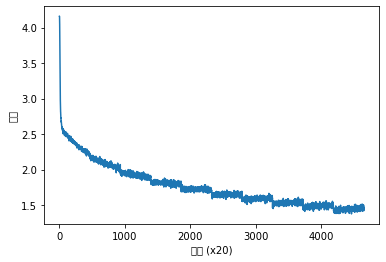

In [17]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
# config.GPU = True
# ===============================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
# from cbow import CBOW
# from skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb


# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)